In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from sklearn.metrics import  mean_squared_error, mean_absolute_error

In [76]:
dataset_dir = "/content/drive/MyDrive/city_temperature.csv"
df=pd.read_csv(dataset_dir)
df.head()

<ipython-input-76-ee014b3adb2a>:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(dataset_dir)


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Region          object 
 1   Country         object 
 2   State           object 
 3   City            object 
 4   Month           int64  
 5   Day             int64  
 6   Year            int64  
 7   AvgTemperature  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 177.4+ MB


In [78]:
# Group by the 'Country' column and count the records for each country
country_counts = df['Country'].value_counts()

# Get the country with the maximum records
country_with_max_records = country_counts.idxmax()
max_records = country_counts.max()

print(f"Country with maximum records: {country_with_max_records} ({max_records} records)")

Country with maximum records: US (1455337 records)


In [79]:
aus_df=df[df['Country']=='Australia']
aus_df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
567781,Australia/South Pacific,Australia,NaN,Brisbane,1,1,1995,76.1
567782,Australia/South Pacific,Australia,NaN,Brisbane,1,2,1995,78.3
567783,Australia/South Pacific,Australia,NaN,Brisbane,1,3,1995,78.6
567784,Australia/South Pacific,Australia,NaN,Brisbane,1,4,1995,78.6
567785,Australia/South Pacific,Australia,NaN,Brisbane,1,5,1995,78.3


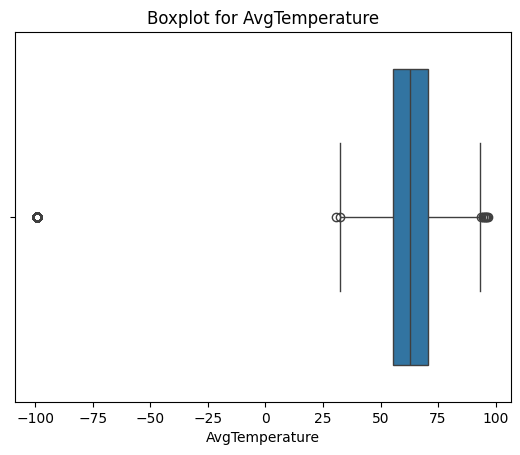

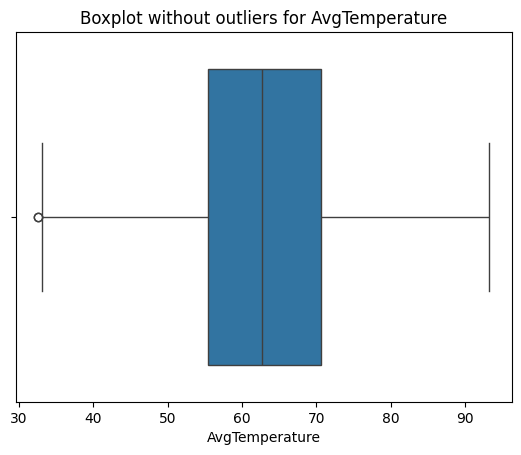

In [80]:
col = 'AvgTemperature'

# Plotting with outliers
sns.boxplot(x=aus_df[col])
plt.title(f'Boxplot for {col}')
plt.show()

# Findind interquartile range
Q1 = aus_df[col].quantile(0.25)
Q3 = aus_df[col].quantile(0.75)
IQR = Q3 - Q1

# Lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering outliers
no_outliers_df = aus_df[(aus_df[col] >= lower_bound) & (aus_df[col] <= upper_bound)]

# plot the boxplot again to confirm that outliers are removed
sns.boxplot(x=no_outliers_df[col])
plt.title(f'Boxplot without outliers for {col}')
plt.show()

In [81]:
#Combining cols to form date
combined_date_df = no_outliers_df.copy()
combined_date_df['Date'] = pd.to_datetime(no_outliers_df[['Year', 'Month', 'Day']])
combined_date_df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature,Date
567781,Australia/South Pacific,Australia,NaN,Brisbane,1,1,1995,76.1,1995-01-01
567782,Australia/South Pacific,Australia,NaN,Brisbane,1,2,1995,78.3,1995-01-02
567783,Australia/South Pacific,Australia,NaN,Brisbane,1,3,1995,78.6,1995-01-03
567784,Australia/South Pacific,Australia,NaN,Brisbane,1,4,1995,78.6,1995-01-04
567785,Australia/South Pacific,Australia,NaN,Brisbane,1,5,1995,78.3,1995-01-05


In [82]:
# Drop unnecessary columns
preprocessed_df = combined_date_df.drop(['Region', 'Country', 'City', 'State', 'Month', 'Day', 'Year'], axis=1)

# Reorder the columns
preprocessed_df = preprocessed_df[['Date','AvgTemperature']]

print ("Shape: ",preprocessed_df.shape)
preprocessed_df.head()

Shape:  (45992, 2)


,Date,AvgTemperature
567781,1995-01-01,76.1
567782,1995-01-02,78.3
567783,1995-01-03,78.6
567784,1995-01-04,78.6
567785,1995-01-05,78.3


In [83]:
#Understanding timeframe
print("Minimum data value : {}".format(preprocessed_df['Date'].min()))
print("Maximum data value : {}".format(preprocessed_df['Date'].max()))

Minimum data value : 1995-01-01 00:00:00
Maximum data value : 2020-05-13 00:00:00


Text(0.5, 1.0, 'Average Temperature in Australia Since 1995-01-01')

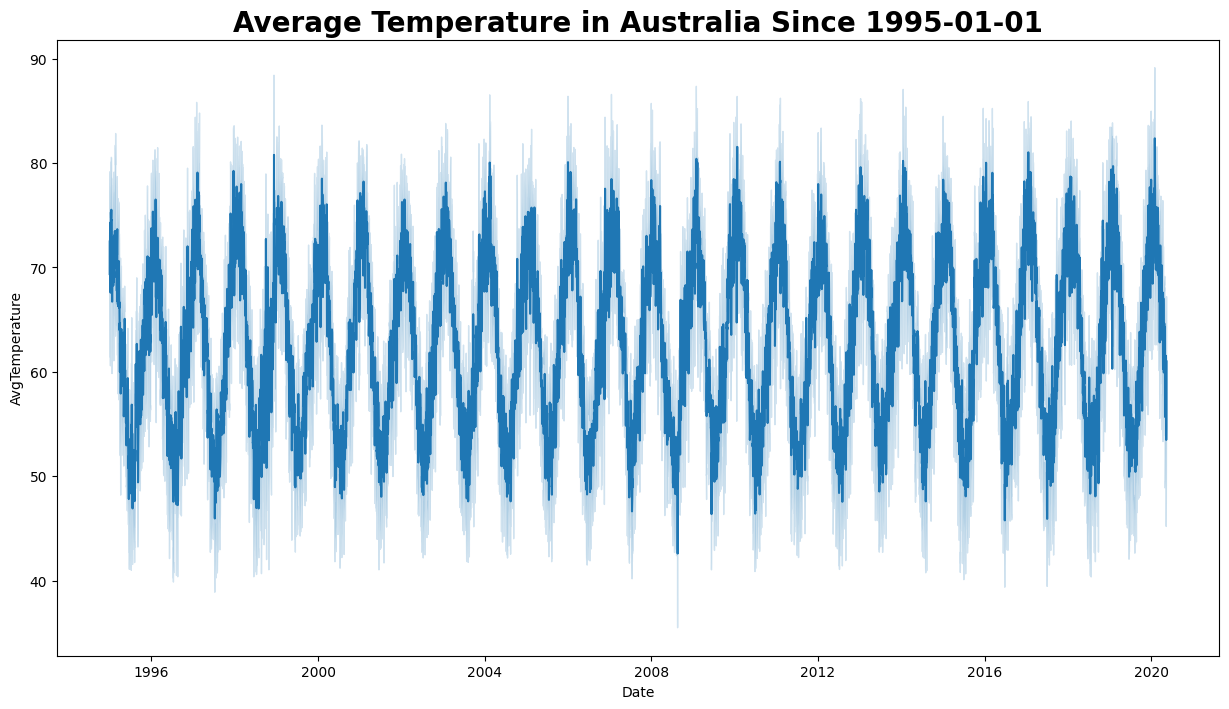

In [84]:
fig=plt.figure(figsize=(15,8))
ax=sns.lineplot(data= preprocessed_df,x="Date",y="AvgTemperature")

plt.title("Average Temperature in Australia Since 1995-01-01",size=20,weight="bold")

In [85]:
# Extracting the 'AvgTemperature' column as the feature 'X'
X = preprocessed_df['AvgTemperature'].values.reshape(-1, 1)

# Getting the length of the dataset
dataset_length = len(preprocessed_df)

# Calculating the number of data points for each split
train_size = int(0.7 * dataset_length)
val_size = int(0.15 * dataset_length)
test_size = int(0.15 * dataset_length)

# Creating training, validation, and test datasets
training_data = X[:train_size]
val_data = X[train_size:train_size + val_size]
test_data = X[train_size + val_size:]

# Print information about the splits
print(f"Total dataset length: {dataset_length}")
print(f"Training set length: {train_size}")
print(f"Validation set length: {val_size}")
print(f"Test set length: {test_size}")

Total dataset length: 45992
Training set length: 32194
Validation set length: 6898
Test set length: 6898


In [86]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_data)
val_set_scaled = sc.fit_transform(val_data)
test_set_scaled = sc.fit_transform(test_data)

In [87]:
input_size=100

# Test data -------------------------------------------------------------
X_train = []
y_train = []
for i in range(input_size, len(training_data)):
    X_train.append(training_set_scaled[i-input_size:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Validation Data -------------------------------------------------------
X_val = []
y_val = []
for i in range(input_size, len(val_data)):
    X_val.append(val_set_scaled[i-input_size:i, 0])
    y_val.append(val_set_scaled[i, 0])

X_val, y_val = np.array(X_val), np.array(y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# Test Data -------------------------------------------------------------
X_test = []
y_test = []
for i in range(input_size, len(test_data)):
    X_test.append(test_set_scaled[i-input_size:i, 0])
    y_test.append(test_set_scaled[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [88]:
model=Sequential()
model.add(LSTM(units = 50, return_sequences= True ,input_shape =(X_train.shape[1],1)))
model.add(Dropout(.2))
model.add(LSTM(units = 50, return_sequences= True))
model.add(Dropout(.2))
model.add(LSTM(units = 50, return_sequences= True))
model.add(Dropout(.2))
model.add(LSTM(units = 50, return_sequences= True))
model.add(Dropout(.2))
model.add(LSTM(units = 50))
model.add(Dropout(.2))
model.add(Dense(units=1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 100, 50)           10400     
                                                                 
 dropout_10 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_11 (LSTM)              (None, 100, 50)           20200     
                                                                 
 dropout_11 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_12 (LSTM)              (None, 100, 50)           20200     
                                                                 
 dropout_12 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_13 (LSTM)              (None, 100, 50)          

In [89]:
callbacks = [
            EarlyStopping(patience = 50, verbose=1),
            ReduceLROnPlateau(factor = 0.5, patience = 10, min_lr = 0.000001, verbose=1),
    ]

model.compile(optimizer='adam',loss= 'mean_squared_error')

In [90]:
history = model.fit(
    X_train,y_train,
    validation_data=(X_val,y_val),
    epochs=100,
    callbacks=callbacks,
    batch_size=32
)

Epoch 1/100
1003/1003 [==============================] - 35s 27ms/step - loss: 0.0102 - val_loss: 0.0121 - lr: 0.0010
Epoch 2/100
1003/1003 [==============================] - 26s 26ms/step - loss: 0.0077 - val_loss: 0.0114 - lr: 0.0010
Epoch 3/100
1003/1003 [==============================] - 24s 24ms/step - loss: 0.0067 - val_loss: 0.0092 - lr: 0.0010
Epoch 4/100
1003/1003 [==============================] - 25s 25ms/step - loss: 0.0050 - val_loss: 0.0073 - lr: 0.0010
Epoch 5/100
1003/1003 [==============================] - 26s 26ms/step - loss: 0.0046 - val_loss: 0.0071 - lr: 0.0010
Epoch 6/100
1003/1003 [==============================] - 24s 24ms/step - loss: 0.0045 - val_loss: 0.0072 - lr: 0.0010
Epoch 7/100
1003/1003 [==============================] - 25s 25ms/step - loss: 0.0044 - val_loss: 0.0070 - lr: 0.0010
Epoch 8/100
1003/1003 [==============================] - 25s 25ms/step - loss: 0.0043 - val_loss: 0.0069 - lr: 0.0010
Epoch 9/100
1003/1003 [==============================] -

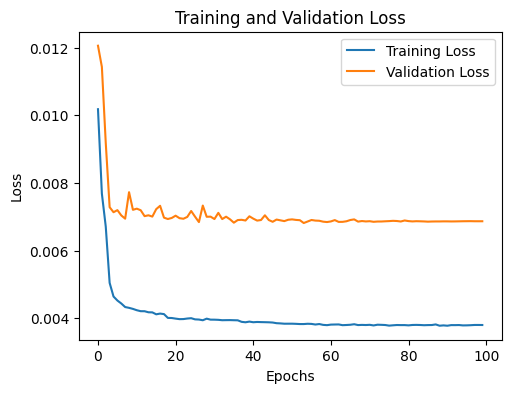

In [91]:
# Access the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create subplots for loss and accuracy
plt.figure(figsize=(12, 4))
# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [92]:
pred=model.predict(X_test)
test=pd.DataFrame(columns=['test','pred'])
test['test']=y_test
test['pred']=pred.flatten()
print(test)

213/213 [==============================] - 3s 9ms/step
          test      pred
0     0.173258  0.217426
1     0.288136  0.205448
2     0.192090  0.265125
3     0.250471  0.190925
4     0.297552  0.251972
...        ...       ...
6795  0.128060  0.299312
6796  0.175141  0.181786
6797  0.263653  0.207520
6798  0.239171  0.264201
6799  0.244821  0.239040

[6800 rows x 2 columns]


Text(500, 1.25, 'Mean Absolute Error :0.08')

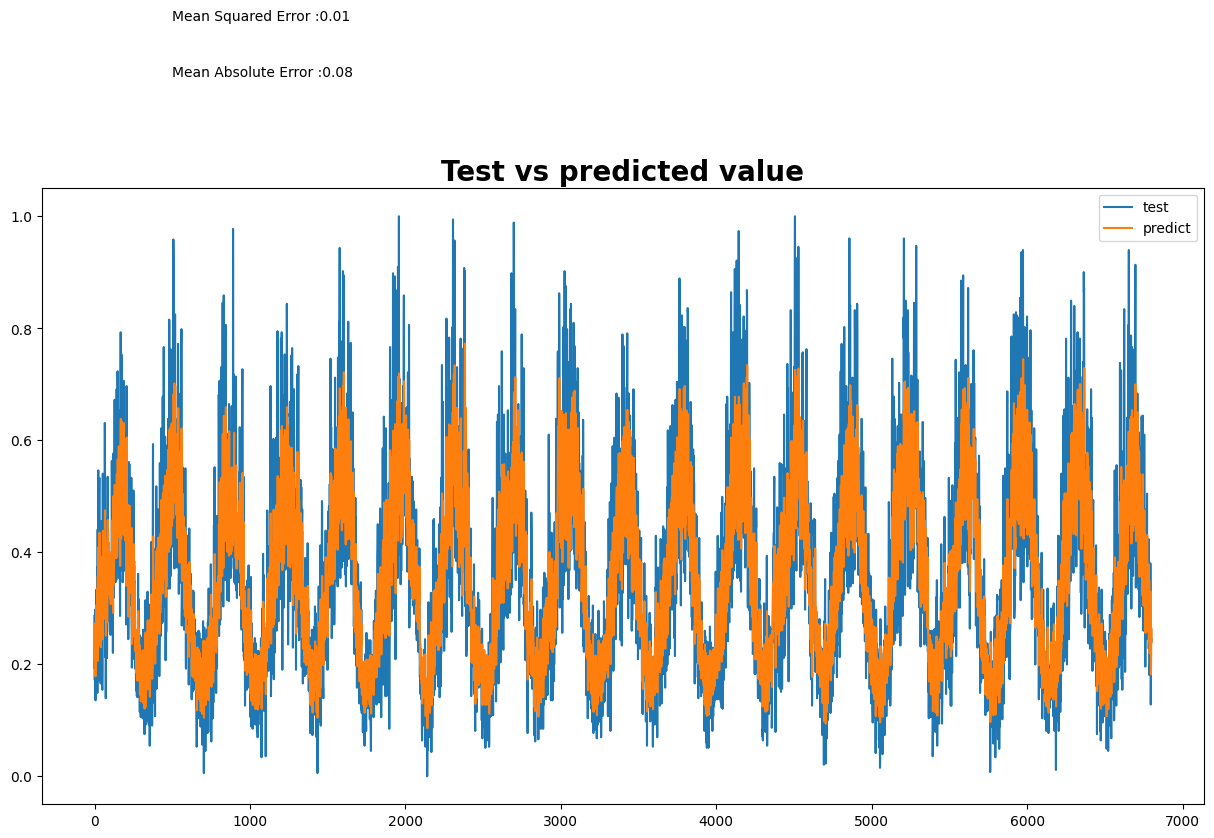

In [93]:
fig=plt.figure(figsize=(15,8))
plt.title("Test vs predicted value",size=20,weight='bold')
plt.plot(test)
plt.legend(['test','predict'])
mse=np.round(mean_squared_error(y_test,pred),2)
mae=np.round(mean_absolute_error(y_test,pred),2)
plt.text(x=500,y=1.35 ,s='Mean Squared Error :{}'.format(mse))
plt.text(x=500,y=1.25, s='Mean Absolute Error :{}'.format(mae))